# DÉTECTION DE PNEUMONIE PAR TRANSFER LEARNING

*Import de libraries et modules nécessaires*
```python

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import  cv2
from IPython.display import clear_output
import mlflow
import joblib  # Pour sauvegarder les scalers
import pickle
from pathlib import Path
import mlflow.sklearn
import mlflow.tensorflow
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tqdm import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = Path("data/chest_xray")


*  TensorFlow et Keras*

In [8]:
# Imports ML/DL
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    precision_score, 
    recall_score,
    f1_score
)
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import (
    DenseNet121,          
    ResNet50,
    EfficientNetB0,
    VGG16,
    InceptionV3,
    MobileNetV2
)

In [9]:
# Imports TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Flatten, BatchNormalization  
from tensorflow.keras.applications import DenseNet121, ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ReduceLROnPlateau, 
    ModelCheckpoint,
    TensorBoard
)

## Import scikit-learn 

In [10]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report
)

## Imports callbacks

In [11]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
    Callback
)

## CHARGEMENT ET PRÉPARATION DES DONNÉES

🧪 TEST EXPLORATION
 EXPLORATION DATASET PNEUMONIA
🌟 EXPLORATION COMPLÈTE DU DATASET
🔍 EXPLORATION DU SPLIT: TRAIN


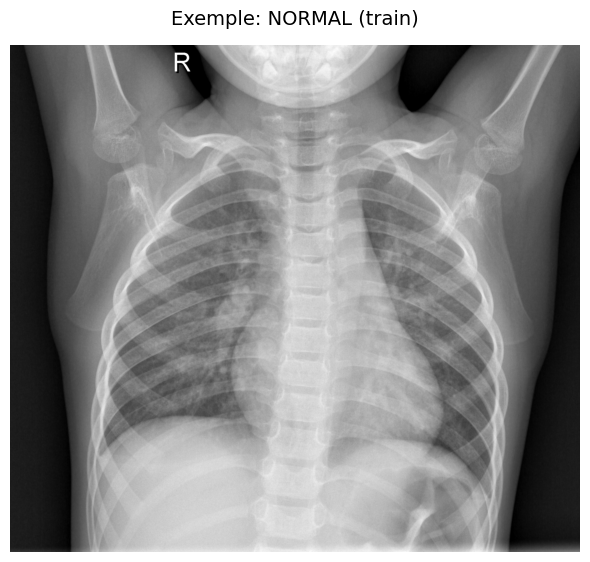

 NORMAL: 1,341 images


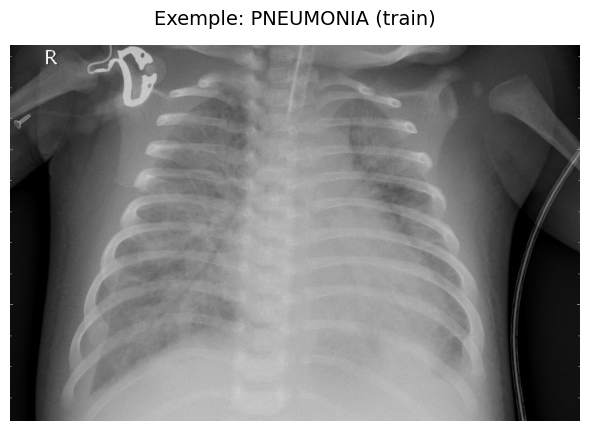

 PNEUMONIA: 565 images

📊 STATISTIQUES TRAIN:
   Total d'images: 1,906
   Classes trouvées: 2
   Tailles d'images uniques: 1867

📐 TAILLES D'IMAGES DÉTECTÉES:
   502x307x3 pixels
   713x353x3 pixels
   620x359x3 pixels
   816x368x3 pixels
   692x383x3 pixels
   904x416x3 pixels
   722x427x3 pixels
   750x440x3 pixels
   763x440x3 pixels
   952x440x3 pixels
   720x441x3 pixels
   635x448x3 pixels
   735x467x3 pixels
   790x472x3 pixels
   904x472x3 pixels
   856x480x3 pixels
   912x480x3 pixels
   928x480x3 pixels
   856x485x3 pixels
   1000x488x3 pixels
   992x496x3 pixels
   860x500x3 pixels
   759x504x3 pixels
   1072x504x3 pixels
   920x512x3 pixels
   976x512x3 pixels
   1016x512x3 pixels
   1152x512x3 pixels
   937x515x3 pixels
   790x519x3 pixels
   984x520x3 pixels
   992x520x3 pixels
   1040x520x3 pixels
   1072x520x3 pixels
   1128x520x3 pixels
   836x521x3 pixels
   858x522x3 pixels
   828x525x3 pixels
   840x528x3 pixels
   862x528x3 pixels
   992x528x3 pixels
   1008x528x3 

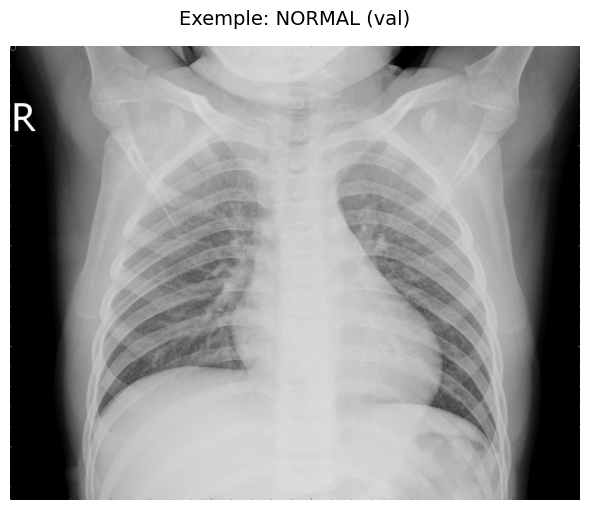

 NORMAL: 8 images


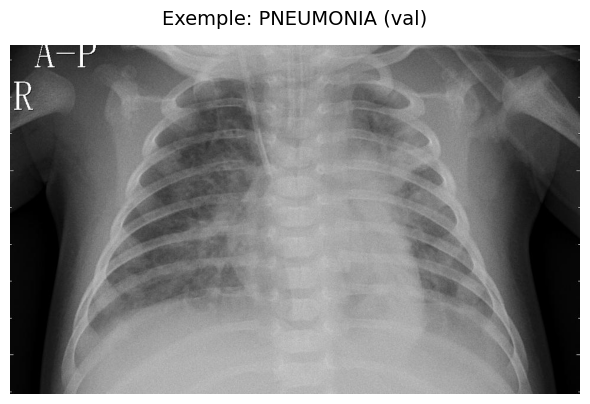

 PNEUMONIA: 8 images

📊 STATISTIQUES VAL:
   Total d'images: 16
   Classes trouvées: 2
   Tailles d'images uniques: 16

📐 TAILLES D'IMAGES DÉTECTÉES:
   968x592x3 pixels
   1016x656x3 pixels
   1152x664x3 pixels
   1072x712x3 pixels
   1256x864x3 pixels
   1288x928x3 pixels
   1416x944x3 pixels
   1192x952x3 pixels
   1272x1040x3 pixels
   1240x1104x3 pixels
   1328x1104x3 pixels
   1664x1128x3 pixels
   1632x1225x3 pixels
   1564x1302x3 pixels
   1736x1416x3 pixels
   1776x1416x3 pixels

 DISTRIBUTION DES CLASSES:
   NORMAL: 8 images (50.0%)
   PNEUMONIA: 8 images (50.0%)

🔍 EXPLORATION DU SPLIT: TEST


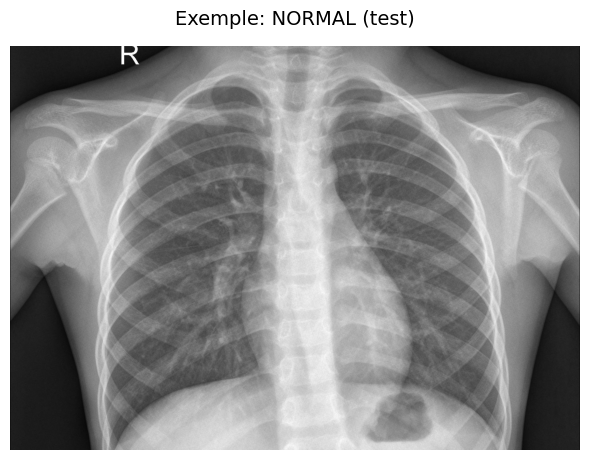

 NORMAL: 234 images


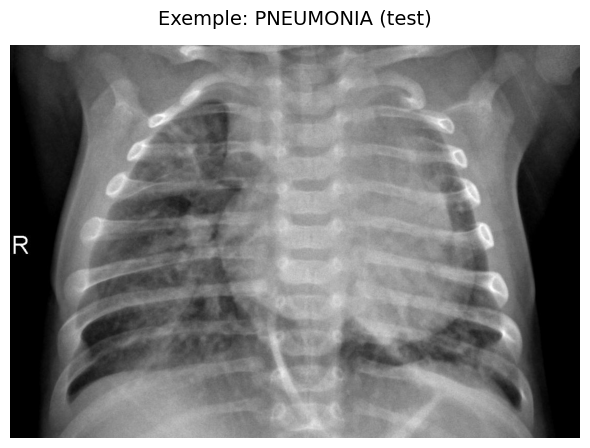

 PNEUMONIA: 390 images

📊 STATISTIQUES TEST:
   Total d'images: 624
   Classes trouvées: 2
   Tailles d'images uniques: 598

📐 TAILLES D'IMAGES DÉTECTÉES:
   888x344x3 pixels
   728x368x3 pixels
   744x416x3 pixels
   744x424x3 pixels
   824x424x3 pixels
   1048x440x3 pixels
   832x448x3 pixels
   1000x448x3 pixels
   840x464x3 pixels
   864x464x3 pixels
   888x464x3 pixels
   1096x472x3 pixels
   856x480x3 pixels
   904x480x3 pixels
   1048x480x3 pixels
   864x496x3 pixels
   936x496x3 pixels
   984x496x3 pixels
   872x504x3 pixels
   952x520x3 pixels
   984x520x3 pixels
   1032x520x3 pixels
   936x528x3 pixels
   944x528x3 pixels
   1120x528x3 pixels
   824x536x3 pixels
   856x536x3 pixels
   880x536x3 pixels
   888x536x3 pixels
   928x536x3 pixels
   944x536x3 pixels
   968x536x3 pixels
   896x544x3 pixels
   960x544x3 pixels
   1000x544x3 pixels
   1016x544x3 pixels
   784x552x3 pixels
   832x552x3 pixels
   856x552x3 pixels
   904x552x3 pixels
   1024x552x3 pixels
   1120x552x3 pi

In [ ]:
class PneumoniaDataLoader:
    """
    Classe pour charger et préprocesser les données avec fit/transform
    """
    
    def __init__(self, data_path, img_size=(224, 224)):
        self.data_path = Path(data_path)
        self.img_size = img_size
        self.scaler = None
        self.label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}
        
    def load_images_from_folder(self, folder_path, max_images=None):
        """
        Charge toutes les images d'un dossier en mémoire
        """
        images = []
        labels = []
        file_paths = []
        
        folder_path = Path(folder_path)
        print(f" Chargement depuis: {folder_path}")
        
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_path = folder_path / class_name
            if not class_path.exists():
                print(f" Dossier manquant: {class_path}")
                continue
                
            # Lister les fichiers images
            image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg'))
            
            if max_images:
                image_files = image_files[:max_images//2]  # Limiter pour test
            
            print(f"   {class_name}: {len(image_files)} images")
            
            # Charger chaque image
            for img_path in tqdm(image_files, desc=f"Chargement {class_name}"):
                try:
                    # Lire et redimensionner l'image
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, self.img_size)
                        
                        images.append(img)
                        labels.append(self.label_mapping[class_name])
                        file_paths.append(str(img_path))
                        
                except Exception as e:
                    print(f" Erreur {img_path}: {e}")
        
        return np.array(images), np.array(labels), file_paths
    
    def load_complete_dataset(self, max_images=None):
        """
        Charge le dataset complet (train, val, test)
        
        Args:
            max_images: Nombre max d'images par split (pour tests rapides)
            
        Returns:
            tuple: ((X_train, y_train, train_paths), (X_val, y_val, val_paths), (X_test, y_test, test_paths))
        """
        print(" CHARGEMENT DATASET COMPLET")
        print("=" * 50)
        
        # Vérifier la structure du dataset
        splits = ['train', 'val', 'test']
        dataset_splits = {}
        
        for split in splits:
            split_path = self.data_path / split
            
            if split_path.exists():
                print(f"\n📂 Chargement {split.upper()}")
                
                # Charger les images de ce split
                X, y, paths = self.load_images_from_folder(split_path, max_images)
                
                if len(X) > 0:
                    dataset_splits[split] = (X, y, paths)
                    print(f" {split}: {len(X)} images chargées")
                    print(f"   Shape: {X.shape}")
                    print(f"   NORMAL: {sum(y == 0)}, PNEUMONIA: {sum(y == 1)}")
                else:
                    print(f" {split}: Aucune image trouvée!")
                    dataset_splits[split] = (np.array([]), np.array([]), [])
            else:
                print(f" Dossier {split} introuvable: {split_path}")
                dataset_splits[split] = (np.array([]), np.array([]), [])
        
        # Vérifier que nous avons au moins train et test
        if 'train' not in dataset_splits or len(dataset_splits['train'][0]) == 0:
            raise ValueError(" Données d'entraînement introuvables!")
        
        if 'test' not in dataset_splits or len(dataset_splits['test'][0]) == 0:
            raise ValueError(" Données de test introuvables!")
        
        # Si pas de validation, créer à partir du train
        if 'val' not in dataset_splits or len(dataset_splits['val'][0]) == 0:
            print("\n Pas de données de validation - Création à partir du train")
            X_train, y_train, train_paths = dataset_splits['train']
            
            # Split train/val 80/20
            from sklearn.model_selection import train_test_split
            X_train_new, X_val, y_train_new, y_val, paths_train_new, paths_val = train_test_split(
                X_train, y_train, train_paths, 
                test_size=0.2, 
                stratify=y_train, 
                random_state=42
            )
            
            dataset_splits['train'] = (X_train_new, y_train_new, paths_train_new)
            dataset_splits['val'] = (X_val, y_val, paths_val)
            
            print(f"✅ Validation créée: {len(X_val)} images")
        
        print(f"\n📊 RÉSUMÉ FINAL:")
        print(f"   Train: {len(dataset_splits['train'][0])} images")
        print(f"   Val:   {len(dataset_splits['val'][0])} images") 
        print(f"   Test:  {len(dataset_splits['test'][0])} images")
        
        return (dataset_splits['train'], 
                dataset_splits['val'], 
                dataset_splits['test'])
    
    def get_dataset_info(self):
        """
        Analyse la structure du dataset sans charger les images
        """
        print("🔍 ANALYSE STRUCTURE DATASET")
        print("=" * 40)
        
        splits = ['train', 'val', 'test']
        dataset_info = {}
        
        for split in splits:
            split_path = self.data_path / split
            
            if split_path.exists():
                split_info = {}
                
                for class_name in ['NORMAL', 'PNEUMONIA']:
                    class_path = split_path / class_name
                    
                    if class_path.exists():
                        # Compter les fichiers
                        image_count = len(list(class_path.glob('*.jpeg'))) + len(list(class_path.glob('*.jpg')))
                        split_info[class_name] = image_count
                    else:
                        split_info[class_name] = 0
                
                dataset_info[split] = split_info
                total = sum(split_info.values())
                
                print(f"\n{split.upper()}:")
                print(f"   NORMAL: {split_info['NORMAL']:,}")
                print(f"   PNEUMONIA: {split_info['PNEUMONIA']:,}")
                print(f"   Total: {total:,}")
                
                if total > 0:
                    normal_pct = (split_info['NORMAL'] / total) * 100
                    pneumonia_pct = (split_info['PNEUMONIA'] / total) * 100
                    print(f"   Ratio: {normal_pct:.1f}% NORMAL, {pneumonia_pct:.1f}% PNEUMONIA")
                    
            else:
                print(f"\n{split.upper()}: Dossier introuvable")
                dataset_info[split] = {'NORMAL': 0, 'PNEUMONIA': 0}
        
        return dataset_info
    
    def explore_images(self, split='train', img_read_type=cv2.IMREAD_COLOR, show_examples=True):
        """
        Explore un répertoire d'images organisé par classe (basé sur votre fonction).
        - Affiche la première image de chaque sous-dossier.
        - Compte le nombre total d'images.
        - Recueille les tailles uniques des images rencontrées.
        
        Parameters
        ----------
        split : str
            Le split à explorer ('train', 'val', 'test')
        img_read_type : int
            Mode de lecture OpenCV (cv2.IMREAD_COLOR ou cv2.IMREAD_GRAYSCALE)
        show_examples : bool
            Si True, affiche des exemples d'images
        """
        
        data_dir = self.data_path / split
        
        if not data_dir.exists():
            print(f" Dossier {split} introuvable: {data_dir}")
            return
        
        print(f"🔍 EXPLORATION DU SPLIT: {split.upper()}")
        print("=" * 50)
        
        unique_shapes = set()
        displayed = set()
        total_images = 0
        class_counts = {}
        
        # Explorer chaque classe
        for label_name in os.listdir(data_dir):
            class_dir = os.path.join(data_dir, label_name)
            if not os.path.isdir(class_dir):
                continue
            
            class_image_count = 0
            
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    filepath = os.path.join(class_dir, filename)
                    img = cv2.imread(filepath, img_read_type)
                    if img is None:
                        continue  # image illisible
                    
                    unique_shapes.add(img.shape)
                    total_images += 1
                    class_image_count += 1
                    
                    # Afficher la première image de chaque dossier
                    if show_examples and label_name not in displayed:
                        displayed.add(label_name)
                        plt.figure(figsize=(6, 6))
                        
                        if img_read_type == cv2.IMREAD_GRAYSCALE:
                            plt.imshow(img, cmap='gray')
                        else:
                            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                        
                        plt.title(f"Exemple: {label_name} ({split})", fontsize=14, pad=15)
                        plt.axis('off')
                        plt.tight_layout()
                        plt.show()
            
            class_counts[label_name] = class_image_count
            print(f" {label_name}: {class_image_count:,} images")
        
        # Résumé des statistiques
        print(f"\n📊 STATISTIQUES {split.upper()}:")
        print(f"   Total d'images: {total_images:,}")
        print(f"   Classes trouvées: {len(class_counts)}")
        print(f"   Tailles d'images uniques: {len(unique_shapes)}")
        
        # Détail des tailles
        if unique_shapes:
            print(f"\n📐 TAILLES D'IMAGES DÉTECTÉES:")
            for shape in sorted(unique_shapes):
                if len(shape) == 3:
                    print(f"   {shape[1]}x{shape[0]}x{shape[2]} pixels")
                else:
                    print(f"   {shape[1]}x{shape[0]} pixels")
        
        # Distribution des classes
        if class_counts:
            print(f"\n DISTRIBUTION DES CLASSES:")
            for class_name, count in class_counts.items():
                percentage = (count / total_images) * 100 if total_images > 0 else 0
                print(f"   {class_name}: {count:,} images ({percentage:.1f}%)")
        
        return {
            'total_images': total_images,
            'class_counts': class_counts,
            'unique_shapes': list(unique_shapes)
        }
    
    def explore_complete_dataset(self, show_examples=True):
        """
        Explore tous les splits du dataset
        """
        print("🌟 EXPLORATION COMPLÈTE DU DATASET")
        print("=" * 60)
        
        all_stats = {}
        splits = ['train', 'val', 'test']
        
        for split in splits:
            split_path = self.data_path / split
            if split_path.exists():
                stats = self.explore_images(split, cv2.IMREAD_COLOR, show_examples)
                all_stats[split] = stats
                print()  # Ligne vide entre les splits
            else:
                print(f" Split {split} non trouvé\n")
        
        # Résumé global
        if all_stats:
            print(" RÉSUMÉ GLOBAL DU DATASET")
            print("=" * 40)
            
            total_global = sum(stats['total_images'] for stats in all_stats.values())
            print(f" Total général: {total_global:,} images")
            
            # Distribution par split
            print(f"\n RÉPARTITION PAR SPLIT:")
            for split, stats in all_stats.items():
                percentage = (stats['total_images'] / total_global) * 100 if total_global > 0 else 0
                print(f"   {split.capitalize()}: {stats['total_images']:,} images ({percentage:.1f}%)")
            
            # Classes globales
            all_classes = set()
            for stats in all_stats.values():
                all_classes.update(stats['class_counts'].keys())
            
            print(f"\n CLASSES DÉTECTÉES: {', '.join(sorted(all_classes))}")
        
        return all_stats
    
    def load_sample_images(self, n_samples=5, split='train'):
        """
        Charge quelques images d'exemple pour visualisation
        """
        sample_images = []
        sample_labels = []
        sample_classes = []
        
        split_path = self.data_path / split
        
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_path = split_path / class_name
            
            if class_path.exists():
                image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg'))
                
                # Prendre les premiers échantillons
                selected_files = image_files[:n_samples//2]
                
                for img_path in selected_files:
                    try:
                        img = cv2.imread(str(img_path))
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, self.img_size)
                            
                            sample_images.append(img)
                            sample_labels.append(self.label_mapping[class_name])
                            sample_classes.append(class_name)
                    except Exception as e:
                        print(f"Erreur échantillon {img_path}: {e}")
        
        return np.array(sample_images), np.array(sample_labels), sample_classes


# Fonction d'aide pour tester rapidement
def test_data_loader(data_path, max_images=100):
    """
    Test rapide du DataLoader
    """
    print(" TEST DU DATALOADER")
    print("=" * 30)
    
    loader = PneumoniaDataLoader(data_path)
    
    # 1. Analyser la structure
    dataset_info = loader.get_dataset_info()
    
    # 2. Charger un petit échantillon
    try:
        print(f"\n🔄 Test chargement {max_images} images...")
        (X_train, y_train, _), (X_val, y_val, _), (X_test, y_test, _) = loader.load_complete_dataset(max_images)
        
        print(f" Chargement réussi!")
        print(f"   Train: {X_train.shape}")
        print(f"   Val: {X_val.shape}")
        print(f"   Test: {X_test.shape}")
        
        return True
        
    except Exception as e:
        print(f" Erreur: {e}")
        return False


# Fonctions d'utilisation rapide basées sur votre style
def explore_pneumonia_dataset(data_path, show_examples=True):
    """
    Version directe de votre fonction explore_images adaptée pour pneumonia
    """
    print(" EXPLORATION DATASET PNEUMONIA")
    print("=" * 50)
    
    loader = PneumoniaDataLoader(data_path)
    
    # Explorer tous les splits
    stats = loader.explore_complete_dataset(show_examples=show_examples)
    
    return stats

def quick_explore_split(data_path, split='train', show_examples=True):
    """
    Exploration rapide d'un split spécifique (comme votre fonction originale)
    """
    loader = PneumoniaDataLoader(data_path)
    return loader.explore_images(split, cv2.IMREAD_COLOR, show_examples)

# Test rapide (à exécuter pour vérifier)
if __name__ == "__main__":
    # Utilisation directe comme votre code original
    print("🧪 TEST EXPLORATION")
    print("=" * 30)
    
    # Explorer le dataset complet
    stats = explore_pneumonia_dataset(DATA_PATH, show_examples=True)
    







## Affichage d'images d'exemple

In [13]:
def display_image_grid(images, titles, rows=2, cols=3, figsize=(15, 10)):
    """
    Affiche une grille d'images avec titres
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()
    
    for i, (img, title) in enumerate(zip(images, titles)):
        if i < len(axes):
            if len(img.shape) == 3:
                axes[i].imshow(img, cmap='gray')
            else:
                axes[i].imshow(img, cmap='gray')
            axes[i].set_title(title, fontsize=14, pad=10)
            axes[i].axis('off')
    
    # Masquer les axes non utilisés
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Charge et préprocesse une image pour le modèle
    """
    try:
        # Lecture de  l'image
        img = cv2.imread(str(image_path))
        if img is None:
            return None
        
        # Conversion BGR -> RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Redimensionnement
        img = cv2.resize(img, target_size)
        
        # Normalisation
        img = img.astype(np.float32) / 255.0
        
        return img
    except Exception as e:
        print(f"Erreur lors du chargement de {image_path}: {e}")
        return None




## Exploration des données

📸 ÉCHANTILLONS D'IMAGES DU DATASET


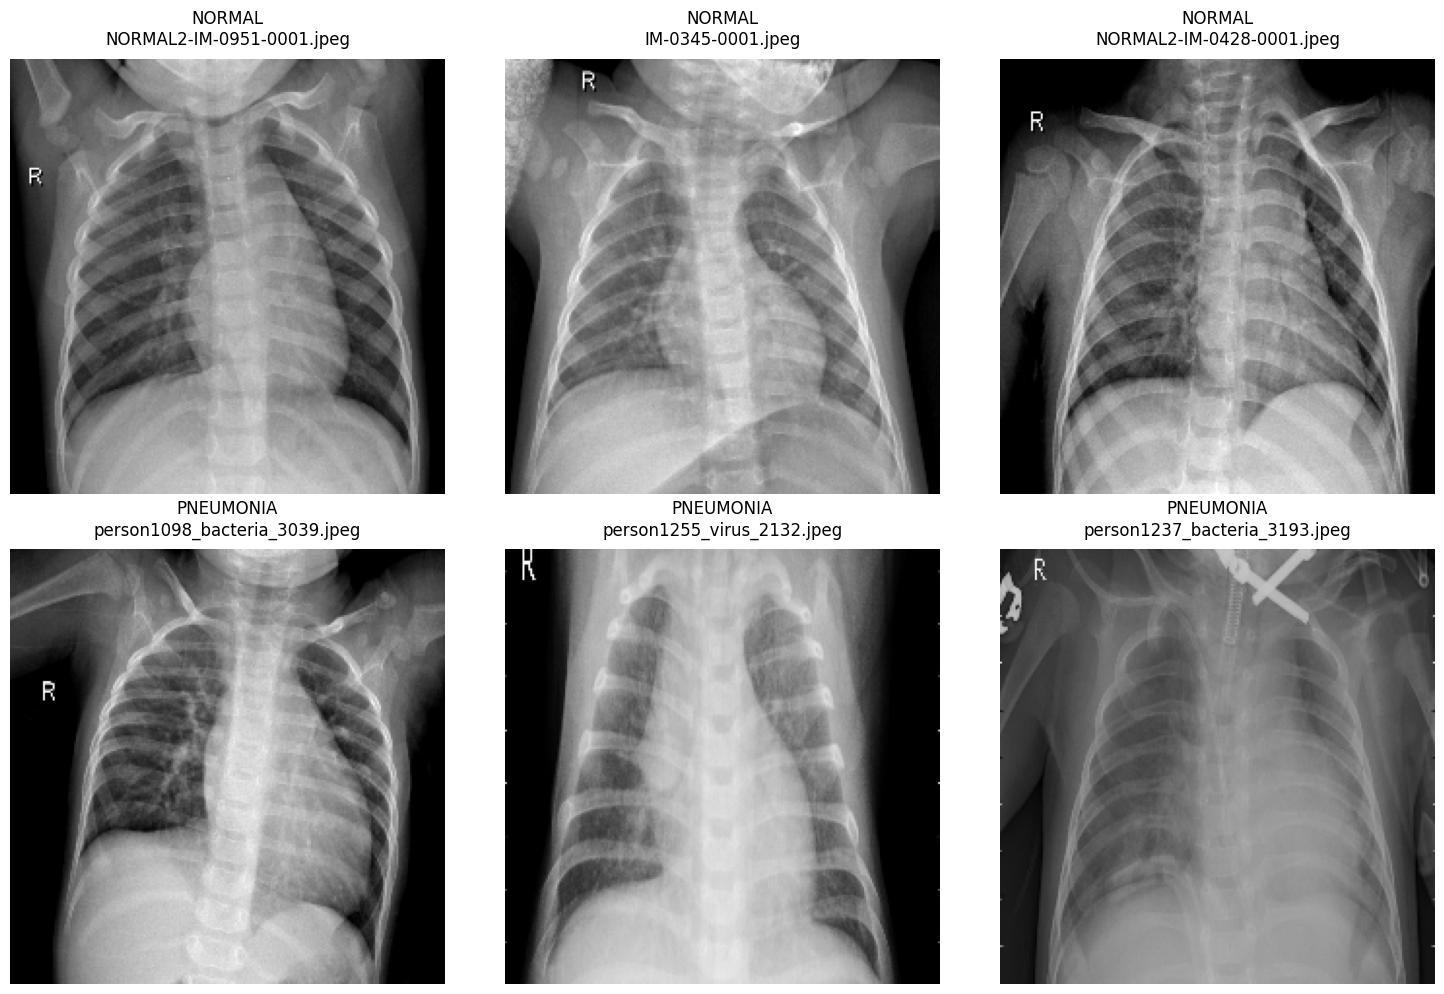

✅ 6 images affichées


In [ ]:
def sample_images_from_dataset(data_path, n_samples=6):
    """
    Échantillonne des images du dataset pour visualisation
    """
    samples = {'images': [], 'titles': [], 'paths': []}
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = data_path / 'train' / class_name
        if class_path.exists():
            image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg'))
            
            n_class_samples = n_samples // 2
            selected_files = np.random.choice(image_files, 
                                            size=min(n_class_samples, len(image_files)), 
                                            replace=False)
            
            for img_path in selected_files:
                try:
                    #  Fonction corrigée
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (224, 224))
                        img = img.astype(np.float32) / 255.0  # Normalisation
                        
                        samples['images'].append(img)
                        samples['titles'].append(f"{class_name}\n{img_path.name}")
                        samples['paths'].append(str(img_path))
                except Exception as e:
                    print(f"Erreur {img_path}: {e}")
    
    return samples

def display_image_grid(images, titles, rows=2, cols=3, figsize=(15, 10)):
    """
     Fonction display_image_grid corrigée
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()
    
    for i, (img, title) in enumerate(zip(images, titles)):
        if i < len(axes):
            axes[i].imshow(img)
            axes[i].set_title(title, fontsize=12, pad=10)
            axes[i].axis('off')
    
    # Masquer les axes non utilisés
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

#  Test sécurisé
DATA_PATH = Path("data/chest_xray")

if DATA_PATH.exists():
    print("📸 ÉCHANTILLONS D'IMAGES DU DATASET")
    print("=" * 40)
    
    try:
        sample_data = sample_images_from_dataset(DATA_PATH, n_samples=6)
        
        if sample_data['images']:
            display_image_grid(
                sample_data['images'], 
                sample_data['titles'],
                rows=2, 
                cols=3, 
                figsize=(15, 10)
            )
            print(f" {len(sample_data['images'])} images affichées")
        else:
            print(" Aucune image trouvée pour l'échantillonnage")
            
    except Exception as e:
        print(f" Erreur dans l'échantillonnage: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f" Chemin DATA_PATH introuvable: {DATA_PATH}")

## Analyse de la structure du dataset

In [15]:
def analyze_dataset_structure(data_path):
    """
    Analyse la structure du dataset
    """
    print("-- ANALYSE DE LA STRUCTURE DU DATASET --")
    print("=" * 50)
    
    splits = ['train', 'val', 'test']
    classes = ['NORMAL', 'PNEUMONIA']
    
    data_info = {}
    
    for split in splits:
        split_path = data_path / split
        if split_path.exists():
            print(f"\n Split: {split.upper()}")
            split_info = {}
            
            for class_name in classes:
                class_path = split_path / class_name
                if class_path.exists():
                    image_count = len(list(class_path.glob('*.jpeg'))) + len(list(class_path.glob('*.jpg')))
                    split_info[class_name] = image_count
                    print(f"   {class_name}: {image_count:,} images")
                else:
                    split_info[class_name] = 0
                    print(f"   {class_name}: Dossier introuvable")
            
            data_info[split] = split_info
        else:
            print(f"\n Split {split} introuvable")
    
    return data_info

def plot_class_distribution(data_info):
    """
    Visualise la distribution des classes
    """
    # Préparer les données pour le graphique
    splits = list(data_info.keys())
    normal_counts = [data_info[split].get('NORMAL', 0) for split in splits]
    pneumonia_counts = [data_info[split].get('PNEUMONIA', 0) for split in splits]
    
    # Créer le graphique
    x = np.arange(len(splits))
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1: Barres groupées
    ax1.bar(x - width/2, normal_counts, width, label='NORMAL', alpha=0.8)
    ax1.bar(x + width/2, pneumonia_counts, width, label='PNEUMONIA', alpha=0.8)
    ax1.set_xlabel('Split')
    ax1.set_ylabel('Nombre d\'images')
    ax1.set_title('Distribution des Classes par Split')
    ax1.set_xticks(x)
    ax1.set_xticklabels([s.capitalize() for s in splits])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, (normal, pneumonia) in enumerate(zip(normal_counts, pneumonia_counts)):
        ax1.text(i - width/2, normal + 50, str(normal), ha='center', va='bottom')
        ax1.text(i + width/2, pneumonia + 50, str(pneumonia), ha='center', va='bottom')
    
    # Graphique 2: Proportion par split
    for i, split in enumerate(splits):
        total = normal_counts[i] + pneumonia_counts[i]
        if total > 0:
            normal_pct = (normal_counts[i] / total) * 100
            pneumonia_pct = (pneumonia_counts[i] / total) * 100
            
            ax2.bar(split.capitalize(), normal_pct, label='NORMAL' if i == 0 else "", alpha=0.8)
            ax2.bar(split.capitalize(), pneumonia_pct, bottom=normal_pct, 
            label='PNEUMONIA' if i == 0 else "", alpha=0.8)
    
    ax2.set_ylabel('Pourcentage')
    ax2.set_title('Proportion des Classes par Split')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def calculate_class_weights(data_info, split='train'):
    """
    Calcule les poids des classes pour gérer le déséquilibre
    """
    normal_count = data_info[split]['NORMAL']
    pneumonia_count = data_info[split]['PNEUMONIA']
    
    total = normal_count + pneumonia_count
    
    # Poids inversement proportionnels à la fréquence
    weight_normal = total / (2 * normal_count)
    weight_pneumonia = total / (2 * pneumonia_count)
    
    class_weights = {0: weight_normal, 1: weight_pneumonia}
    
    print(f" POIDS DES CLASSES (basés sur {split}):")
    print(f" NORMAL (0): {weight_normal:.3f}")
    print(f" PNEUMONIA (1): {weight_pneumonia:.3f}")
    print(f" Ratio: {weight_pneumonia/weight_normal:.2f}:1")
    
    return class_weights

## ANALYSE DES CARACTÉRISTIQUES D'IMAGES

🔍 ANALYSE DES PROPRIÉTÉS D'IMAGES
 Statistiques sur 200 images:

Dimensions:
   Largeur: 713-2566 pixels
   Hauteur: 353-2519 pixels

Intensité des pixels:
   Moyenne: 124.6 ± 15.9
   Écart-type: 59.0 ± 8.3


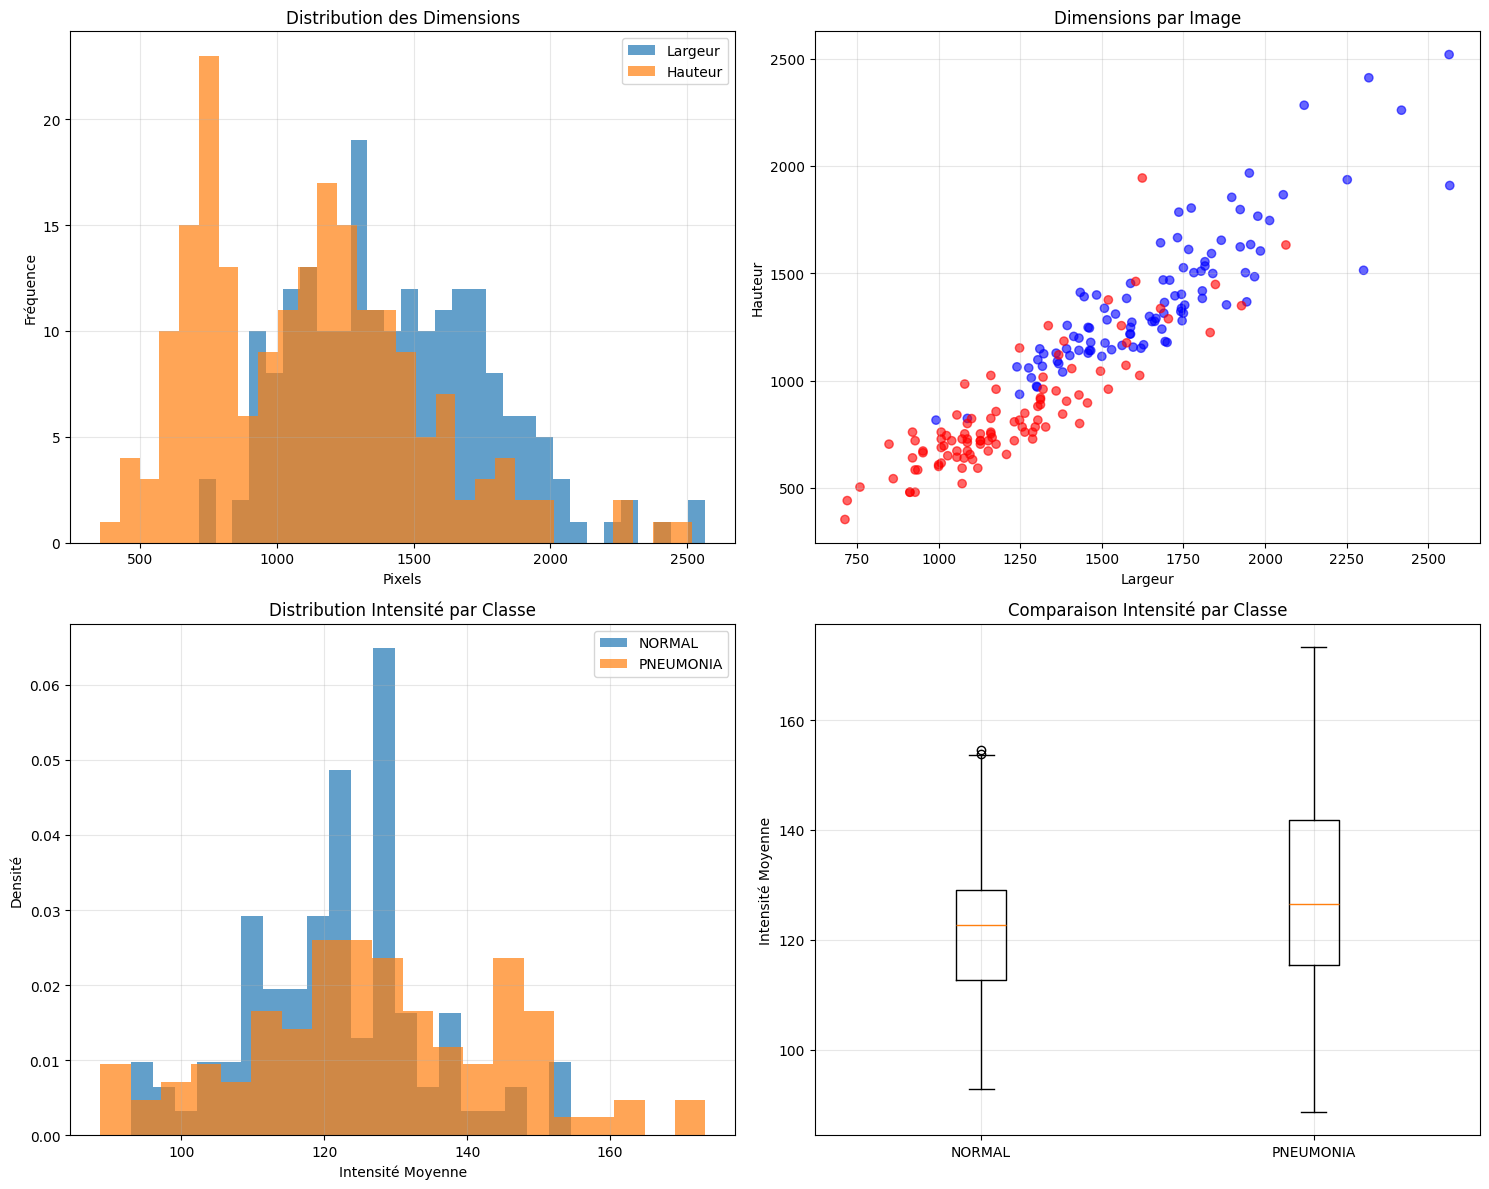

     widths  heights  mean_intensities  std_intensities    classes
0      1304     1097        120.829932        57.656241     NORMAL
1      1662     1276        120.339514        61.826047     NORMAL
2      1462     1140        111.736945        56.040824     NORMAL
3      1458     1248        104.173867        63.727045     NORMAL
4      1576     1383        129.129912        57.796129     NORMAL
..      ...      ...               ...              ...        ...
195     861      543        107.077956        37.102277  PNEUMONIA
196    1560     1256        129.686253        77.967298  PNEUMONIA
197     952      664        121.164041        50.262967  PNEUMONIA
198    1520      960        145.472857        71.311253  PNEUMONIA
199     759      504        171.484456        36.303854  PNEUMONIA

[200 rows x 5 columns]


In [16]:

def analyze_image_properties(data_path, n_samples=100):
    """
    Analyse les propriétés des images (dimensions, distribution de pixels)
    """
    print("🔍 ANALYSE DES PROPRIÉTÉS D'IMAGES")
    print("=" * 50)
    
    image_stats = {
        'widths': [],
        'heights': [],
        'mean_intensities': [],
        'std_intensities': [],
        'classes': []
    }
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = data_path / 'train' / class_name
        if class_path.exists():
            image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg'))
            
            # Échantillonner pour l'analyse
            sample_size = min(n_samples // 2, len(image_files))
            selected_files = np.random.choice(image_files, size=sample_size, replace=False)
            
            for img_path in selected_files:
                try:
                    # Lire l'image originale pour les dimensions
                    img_original = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                    if img_original is not None:
                        h, w = img_original.shape
                        
                        image_stats['widths'].append(w)
                        image_stats['heights'].append(h)
                        image_stats['mean_intensities'].append(np.mean(img_original))
                        image_stats['std_intensities'].append(np.std(img_original))
                        image_stats['classes'].append(class_name)
                        
                except Exception as e:
                    print(f"Erreur avec {img_path}: {e}")
    
    # Convertir en DataFrame pour l'analyse
    df_stats = pd.DataFrame(image_stats)
    
    # Afficher les statistiques
    print(f" Statistiques sur {len(df_stats)} images:")
    print("\nDimensions:")
    print(f"   Largeur: {df_stats['widths'].min()}-{df_stats['widths'].max()} pixels")
    print(f"   Hauteur: {df_stats['heights'].min()}-{df_stats['heights'].max()} pixels")
    
    print("\nIntensité des pixels:")
    print(f"   Moyenne: {df_stats['mean_intensities'].mean():.1f} ± {df_stats['mean_intensities'].std():.1f}")
    print(f"   Écart-type: {df_stats['std_intensities'].mean():.1f} ± {df_stats['std_intensities'].std():.1f}")
    
    # Visualisations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Distribution des dimensions
    axes[0, 0].hist(df_stats['widths'], bins=30, alpha=0.7, label='Largeur')
    axes[0, 0].hist(df_stats['heights'], bins=30, alpha=0.7, label='Hauteur')
    axes[0, 0].set_xlabel('Pixels')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].set_title('Distribution des Dimensions')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Scatter plot dimensions
    colors = ['blue' if c == 'NORMAL' else 'red' for c in df_stats['classes']]
    axes[0, 1].scatter(df_stats['widths'], df_stats['heights'], c=colors, alpha=0.6)
    axes[0, 1].set_xlabel('Largeur')
    axes[0, 1].set_ylabel('Hauteur')
    axes[0, 1].set_title('Dimensions par Image')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Distribution intensité par classe
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_data = df_stats[df_stats['classes'] == class_name]
        axes[1, 0].hist(class_data['mean_intensities'], bins=20, alpha=0.7, 
        label=class_name, density=True)
        axes[1, 0].set_xlabel('Intensité Moyenne')
        axes[1, 0].set_ylabel('Densité')
        axes[1, 0].set_title('Distribution Intensité par Classe')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Box plot comparaison classes
    class_comparison = []
    labels = []
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_data = df_stats[df_stats['classes'] == class_name]
        class_comparison.append(class_data['mean_intensities'])
        labels.append(class_name)
    
    axes[1, 1].boxplot(class_comparison, labels=labels)
    axes[1, 1].set_ylabel('Intensité Moyenne')
    axes[1, 1].set_title('Comparaison Intensité par Classe')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(df_stats)

# Analyser les propriétés des images
if DATA_PATH.exists():
    image_properties = analyze_image_properties(DATA_PATH, n_samples=200)

## Visualisation de la distribution des classes 

DataFrame:
   Split      Class  Count
0  train     NORMAL   1341
1  train  PNEUMONIA   3875
2   test     NORMAL    234
3   test  PNEUMONIA    390


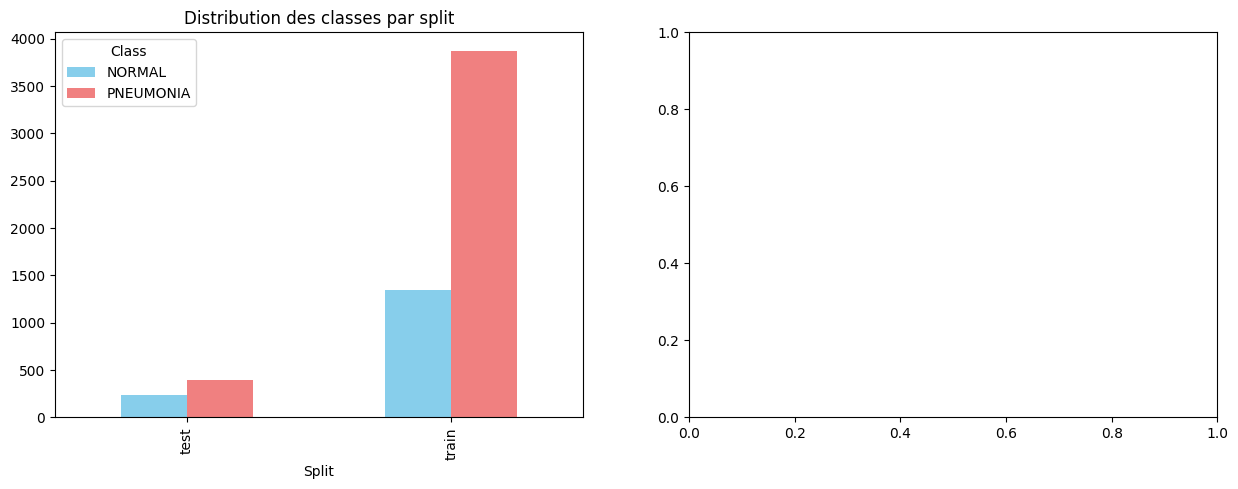

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Données minimales
df = pd.DataFrame({
    'Split': ['train', 'train', 'test', 'test'],
    'Class': ['NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA'],
    'Count': [1341, 3875, 234, 390]
})

print("DataFrame:")
print(df)

# Visualisation de la distribution des classes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

df_pivot = df.pivot(index='Split', columns='Class', values='Count')
df_pivot.plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Distribution des classes par split')

plt.show()


## Peprocessing des données

In [18]:
class ImagePreprocessor:
    """
    Classe pour le preprocessing des images avec fit/transform
    """
    
    def __init__(self, scaler_type='standard'):
        """
        scaler_type: 'standard', 'minmax', 'robust'
        """
        self.scaler_type = scaler_type
        self.scaler = None
        self.is_fitted = False
        
        # Choisir le type de scaler
        if scaler_type == 'standard':
            self.scaler = StandardScaler()
        elif scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
        elif scaler_type == 'robust':
            self.scaler = RobustScaler()
        else:
            raise ValueError(f"scaler_type '{scaler_type}' non supporté")
    
    def prepare_images_for_scaling(self, images):
        """
        Prépare les images pour le scaling (aplatit les dimensions)
        """
        n_samples = images.shape[0]
        # Aplatir: (n_samples, height, width, channels) → (n_samples, height*width*channels)
        images_flattened = images.reshape(n_samples, -1)
        
        print(f" Shape preprocessing:")
        print(f"   Originale: {images.shape}")
        print(f"   Aplatie: {images_flattened.shape}")
        
        return images_flattened
    
    def fit(self, X_train_images):
        """
        FIT: Apprend les paramètres de normalisation sur les données d'entraînement
        """
        print(f" FIT du {self.scaler_type}Scaler...")
        
        # Préparer les images
        X_train_flat = self.prepare_images_for_scaling(X_train_images)
        
        # FIT sur les données d'entraînement
        self.scaler.fit(X_train_flat)
        self.is_fitted = True
        
        # Statistiques apprises
        if hasattr(self.scaler, 'mean_'):
            print(f"    Moyenne apprise: {self.scaler.mean_.mean():.6f}")
            print(f"    Écart-type appris: {self.scaler.scale_.mean():.6f}")
        elif hasattr(self.scaler, 'data_min_'):
            print(f"    Min appris: {self.scaler.data_min_.mean():.6f}")
            print(f"    Max appris: {self.scaler.data_max_.mean():.6f}")
        
        print(" FIT terminé")
        
    def transform(self, images):
        """
        TRANSFORM: Applique la normalisation apprise
        """
        if not self.is_fitted:
            raise ValueError("Le scaler doit être fitté avant transform")
        
        print(f" TRANSFORM avec {self.scaler_type}Scaler...")
        
        # Sauvegarder la shape originale
        original_shape = images.shape
        
        # Aplatir et transformer
        images_flat = self.prepare_images_for_scaling(images)
        images_scaled_flat = self.scaler.transform(images_flat)
        
        # Remettre en forme originale
        images_scaled = images_scaled_flat.reshape(original_shape)
        
        print(f"    {images.shape[0]} images transformées")
        print(f"    Nouvelle moyenne: {images_scaled.mean():.6f}")
        print(f"    Nouvel écart-type: {images_scaled.std():.6f}")
        
        return images_scaled
    
    def fit_transform(self, X_train_images):
        """
        FIT_TRANSFORM: Fit puis transform en une étape
        """
        print(f"⚡ FIT_TRANSFORM avec {self.scaler_type}Scaler...")
        self.fit(X_train_images)
        return self.transform(X_train_images)
    
    def save_scaler(self, filepath):
        """
        Sauvegarde le scaler fitté
        """
        if not self.is_fitted:
            print(" Scaler pas encore fitté")
            return False
            
        try:
            joblib.dump(self.scaler, filepath)
            print(f" Scaler sauvegardé: {filepath}")
            return True
        except Exception as e:
            print(f" Erreur sauvegarde: {e}")
            return False
    
    def load_scaler(self, filepath):
        """
        Charge un scaler pré-fitté
        """
        try:
            self.scaler = joblib.load(filepath)
            self.is_fitted = True
            print(f" Scaler chargé: {filepath}")
            return True
        except Exception as e:
            print(f" Erreur chargement: {e}")
            return False


## Pipeline complet avec fit transform

In [19]:
def create_preprocessing_pipeline(data_path, scaler_type='standard', max_images=None):
    """
    Pipeline complète de preprocessing avec fit/transform
    """
    print(" PIPELINE PREPROCESSING AVEC FIT/TRANSFORM")
    print("=" * 60)
    
    # 1. Charger les données
    loader = PneumoniaDataLoader(data_path, img_size=(224, 224))
    (X_train, y_train, train_paths), (X_val, y_val, val_paths), (X_test, y_test, test_paths) = loader.load_complete_dataset(max_images)
    
    # 2. Créer le preprocessor
    preprocessor = ImagePreprocessor(scaler_type=scaler_type)
    
    # 3. FIT sur les données d'entraînement
    print(f"\n ÉTAPE FIT:")
    X_train_scaled = preprocessor.fit_transform(X_train)
    
    # 4. TRANSFORM sur validation et test
    print(f"\n ÉTAPE TRANSFORM:")
    X_val_scaled = preprocessor.transform(X_val)
    X_test_scaled = preprocessor.transform(X_test)
    
    # 5. Calculer les poids de classe
    from collections import Counter
    class_counts = Counter(y_train)
    total = len(y_train)
    class_weights = {
        0: total / (2 * class_counts[0]),  # NORMAL
        1: total / (2 * class_counts[1])   # PNEUMONIA
    }
    
    print(f"\n POIDS DES CLASSES:")
    print(f"   NORMAL (0): {class_weights[0]:.3f}")
    print(f"   PNEUMONIA (1): {class_weights[1]:.3f}")
    
    # 6. Sauvegarder le scaler
    scaler_path = f"scaler_{scaler_type}_pneumonia.pkl"
    preprocessor.save_scaler(scaler_path)
    
    # 7. Résumé
    print(f"\n DONNÉES PRÉPROCESSÉES:")
    print(f"   Train: {X_train_scaled.shape}")
    print(f"   Val: {X_val_scaled.shape}")
    print(f"   Test: {X_test_scaled.shape}")
    print(f"   Scaler: {scaler_type} sauvegardé dans {scaler_path}")
    
    return {
        'X_train': X_train_scaled,
        'y_train': y_train,
        'X_val': X_val_scaled,
        'y_val': y_val,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'class_weights': class_weights,
        'preprocessor': preprocessor,
        'scaler_path': scaler_path
    }




## MODÈLE AVEC DONNÉES PRÉPROCESSÉES

In [20]:
def create_model_for_preprocessed_data(input_shape):
    """
    Crée un modèle pour les données déjà préprocessées
    """
    print(f" Création modèle Transfer Learning pour shape: {input_shape}")
    
    # Transfer Learning avec DenseNet121
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # Freeze initial
    
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((224, 224, 3), input_shape=(224*224*3,)),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compiler avec learning rate plus bas pour transfer learning
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Plus bas pour transfer learning
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', 'AUC']
    )
    
    print(f" Modèle DenseNet121 créé (couches gelées: {len([l for l in base_model.layers if not l.trainable])}/{len(base_model.layers)})")
    
    return model
    



## Fine-tuning

In [21]:
def fine_tune_model(model, data_dict, fine_tune_epochs=5):
    """
    Fine-tune les dernières couches du modèle pré-entraîné
    
    Args:
        model: Modèle déjà entraîné avec couches gelées
        data_dict: Dictionnaire contenant les données preprocessées
        fine_tune_epochs: Nombre d'epochs pour le fine-tuning
    
    Returns:
        model: Modèle fine-tuné
        history_ft: Historique du fine-tuning
    """
    print(" DÉMARRAGE DU FINE-TUNING")
    print("=" * 40)
    
    # Récupérer les données
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_val = data_dict['X_val']
    y_val = data_dict['y_val']
    class_weights = data_dict['class_weights']
    
    # Dégeler les dernières couches de DenseNet
    base_model = model.layers[1]  # DenseNet est la 2ème couche (après Reshape)
    base_model.trainable = True
    
    # Geler les premières couches (garder les features bas niveau)
    trainable_layers = 0
    for layer in base_model.layers:
        layer.trainable = False
    
    # Dégeler seulement les dernières couches (par exemple les 30 dernières)
    for layer in base_model.layers[-30:]:
        layer.trainable = True
        trainable_layers += 1
    
    print(f" Couches dégelées: {trainable_layers}/{len(base_model.layers)}")
    
    # Recompiler avec learning rate très bas
    model.compile(
        optimizer=Adam(learning_rate=0.00001),  # Très bas pour fine-tuning
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', 'AUC']
    )
    
    print(f" Nouveau learning rate: 0.00001")
    
    # Callbacks pour fine-tuning (plus conservateurs)
    callbacks_ft = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,  # Plus patient pour fine-tuning
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=2,
            factor=0.5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Fine-tuning
    print(f" Début fine-tuning - {fine_tune_epochs} epochs")
    history_ft = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=fine_tune_epochs,
        batch_size=16,  # Plus petit batch pour fine-tuning
        class_weight=class_weights,
        verbose=1,
        callbacks=callbacks_ft
    )
    
    print(" Fine-tuning terminé!")

    # Afficher quelques métriques
    final_val_acc = history_ft.history['val_accuracy'][-1]
    final_val_loss = history_ft.history['val_loss'][-1]
    print(f" Résultats finaux: Val Accuracy = {final_val_acc:.4f}, Val Loss = {final_val_loss:.4f}")
    
    return model, history_ft

## Entrainner le modele avec les données prétraitées

In [22]:
def train_model_with_preprocessed_data(data_dict, epochs=10):
    """
    Entraîne le modèle avec les données préprocessées
    """
    print(" ENTRAÎNEMENT AVEC DONNÉES PRÉPROCESSÉES")
    print("=" * 50)
    
    # Récupérer les données
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_val = data_dict['X_val']
    y_val = data_dict['y_val']
    class_weights = data_dict['class_weights']
    
    # Créer le modèle
    input_shape = X_train.shape[1:]  # Shape sans le batch
    model = create_model_for_preprocessed_data(input_shape)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_recall',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=2,
            factor=0.5
        )
    ]
    
    # Entraînement
    print(f" Début entraînement - {epochs} epochs")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights,
        verbose=1,
        callbacks=callbacks
        
    )
    
    print(" Entraînement terminé!")
    
    return model, history


## ÉVALUATION AVEC FIT/TRANSFORM

In [23]:
def evaluate_model_preprocessed(model, data_dict):
    """
    Évalue le modèle avec les données préprocessées
    """
    print(" ÉVALUATION MODÈLE (FIT/TRANSFORM)")
    print("=" * 40)
    
    # Données de test
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    # Prédictions
    predictions = model.predict(X_test)
    y_pred = (predictions > 0.5).astype(int).flatten()
    
    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("    RÉSULTATS FINAUX:")
    print(f"   Accuracy: {accuracy:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"   Recall: {recall:.3f}")
    print(f"   F1-Score: {f1:.3f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n Matrice de confusion:")
    print(f"   TN: {tn}, FP: {fp}")
    print(f"   FN: {fn}, TP: {tp}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

## PIPELINE COMPLÈT

In [24]:
def complete_fit_transform_pipeline(data_path, scaler_type='standard', epochs=10, max_images=1000):
    """
    Pipeline complète avec fit/transform
    """
    print(" PIPELINE COMPLÈTE FIT/TRANSFORM")
    print("=" * 60)
    
    # 1. Preprocessing
    data_dict = create_preprocessing_pipeline(data_path, scaler_type, max_images)
    
    # 2. Entraînement
    model, history = train_model_with_preprocessed_data(data_dict, epochs)
    
    # 3. Évaluation
    results = evaluate_model_preprocessed(model, data_dict)
    
    # 4. Sauvegarde
    model_path = f"model_pneumonia_fit_transform_{scaler_type}.h5"
    model.save(model_path)
    print(f" Modèle sauvegardé: {model_path}")
    
    return {
        'model': model,
        'history': history,
        'results': results,
        'data_dict': data_dict,
        'model_path': model_path
    }
